In [1]:
# Import the necessary libraries for data manipulation, visualization, and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

Step 1:

Problem Description:

The "Histopathologic Cancer Detection" challenge on Kaggle is aimed at developing models that can classify images of lymph node tissue as either cancerous or non-cancerous. The goal is to assist pathologists in detecting metastatic cancer in small image patches obtained from biopsies. The main challenge is to correctly classify whether a small patch of tissue contains metastatic cancer, which requires analyzing high-resolution microscopy images.

Data Overview:

The dataset consists of high-resolution images of histopathology tissue samples (size: 96x96 pixels) in TIFF format. Each image corresponds to a small tissue section, and each section is labeled as either cancerous (1) or non-cancerous (0). The dataset contains two primary components: Training data and Test data

Key Challenges:

Class Imbalance: There may be a significant imbalance between the cancerous and non-cancerous classes, making it harder to predict the minority class accurately.
Image Processing: The images are small and of high resolution, which requires effective preprocessing and potentially data augmentation to improve model performance.
Model Generalization: The variability in cancerous patterns makes it essential for models to generalize well to unseen data, especially when differentiating subtle features between healthy and cancerous tissue.


In [2]:

# Define paths to the directories containing the train and test datasets
train_dir = './kaggle/input/train'
test_dir = './kaggle/input/test'

# Load train labels from CSV file
train_labels = pd.read_csv('./kaggle/input/train_labels.csv')

# Brief Data Description
print(f"Number of training samples: {train_labels.shape[0]}")
print(f"Number of test samples: {len(os.listdir(test_dir))}")
print(f"Train Labels Columns: {train_labels.columns.tolist()}")
print(f"Number of unique image IDs in train: {train_labels['id'].nunique()}")

# Display basic information about the train labels dataframe
print("Training Labels Info:")
print(train_labels.info())
print("\nSample of Training Labels:")
print(train_labels.head())

# Check for any missing values in the training labels
print("\nMissing Values in Train Labels:")
print(train_labels.isnull().sum())


Number of training samples: 220025
Number of test samples: 57458
Train Labels Columns: ['id', 'label']
Number of unique image IDs in train: 220025
Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Sample of Training Labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Missing Values in Train Labels:
id       0
label    0
dtype: int64


Step 2:
Exploratory Data Analysis

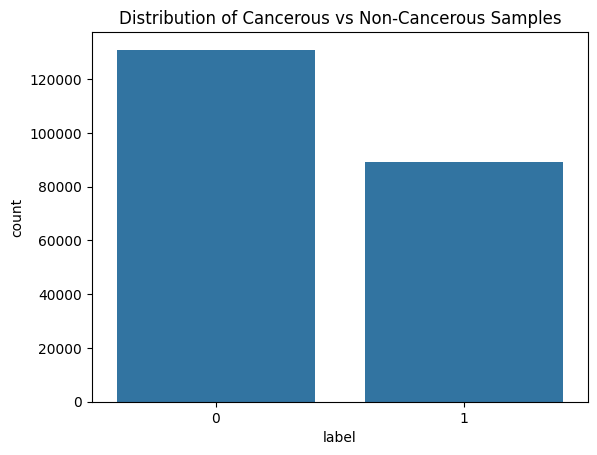

In [3]:
# Check the distribution of labels (Cancerous vs Non-Cancerous)
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Cancerous vs Non-Cancerous Samples')
plt.show()

In [4]:
# Inspect a sample of image sizes (dimensions of a few images)
sample_image_path = os.path.join(train_dir, train_labels['id'][1] + '.tif')
sample_image = Image.open(sample_image_path)
print(f"\nSample Image Size: {sample_image.size}")


Sample Image Size: (96, 96)



Cancerous Images:


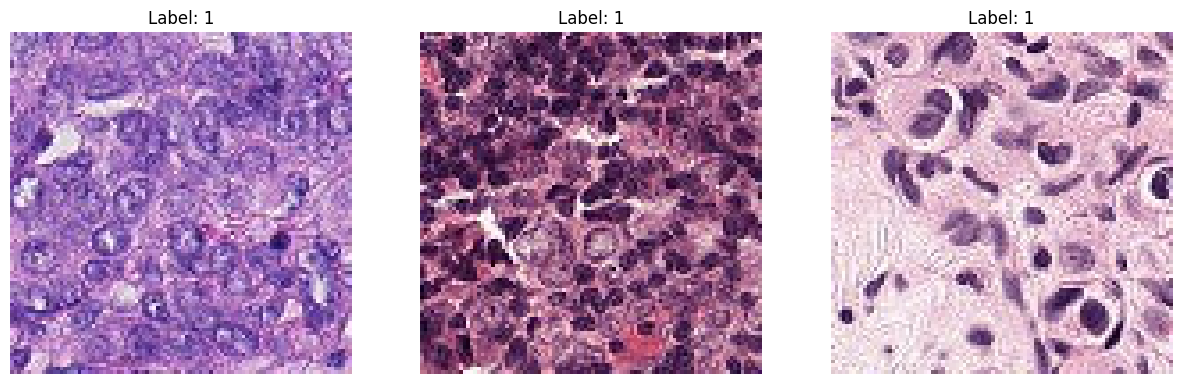


Non-Cancerous Images:


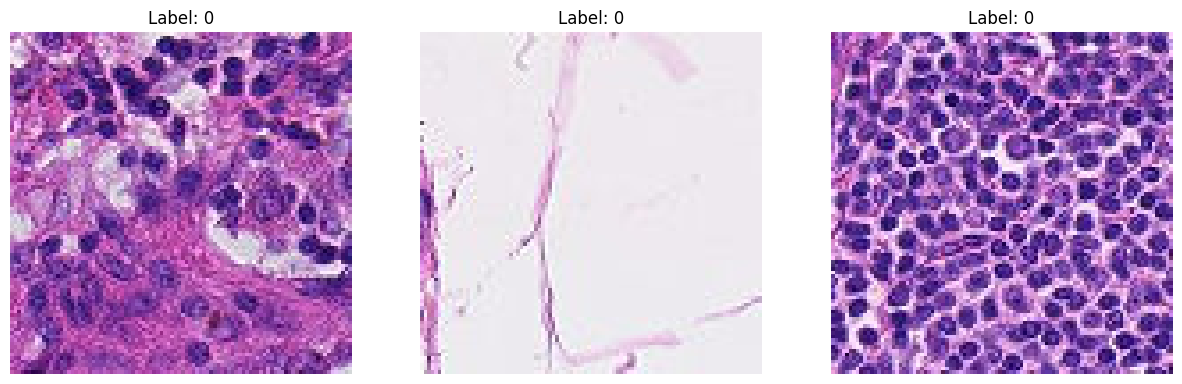

In [5]:
# Visualize a few random images (Cancerous vs Non-Cancerous)
def visualize_random_images(label, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    selected_images = train_labels[train_labels['label'] == label].sample(num_images)['id']
    for i, img_id in enumerate(selected_images):
        if label == 1:
            img_path = os.path.join(train_dir, img_id + '.tif')
        else :
            img_path = os.path.join(train_dir, img_id + '.tif')

        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")
    plt.show()

# Visualize cancerous (label=1) and non-cancerous (label=0) images
print("\nCancerous Images:")
visualize_random_images(label=1)

print("\nNon-Cancerous Images:")
visualize_random_images(label=0)

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to check if a single image is corrupted
def check_image(image_id, directory):
    try:
        img = Image.open(os.path.join(directory, image_id + '.tif'))
        img.verify()  # To ensure the image is not corrupted
        return None  # Image is fine
    except Exception as e:
        return image_id  # Return the image ID if it's corrupted

# Parallelized function to check multiple images
def check_corrupted_images_parallel(image_ids, directory, max_workers=8):
    corrupted_images = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_image = {executor.submit(check_image, img_id, directory): img_id for img_id in image_ids}
        for future in as_completed(future_to_image):
            result = future.result()
            if result:  # If the result is not None, it means the image is corrupted
                corrupted_images.append(result)
    return corrupted_images

# Get all the image IDs from the training dataset
image_ids = train_labels['id'].tolist()

# Define the number of workers (threads) to use, based on your CPU capabilities
num_workers = 8  # You can adjust this depending on your system

# Check for corrupted images in parallel
corrupted_images = check_corrupted_images_parallel(image_ids, train_dir, max_workers=num_workers)

# Output the result
print(f"Corrupted images: {corrupted_images if corrupted_images else 'None found'}")

Corrupted images: None found


Step 3 (DModel Architecture):

Model Architecture for Histopathologic Cancer Detection:

Given that this task is an image classification problem involving histopathological images, the architecture should effectively extract spatial features from the images. Convolutional Neural Networks (CNNs) are particularly well-suited for image classification tasks because they can automatically capture patterns, such as edges and textures, from the images.

Baseline CNN Architecture:

A simple CNN model can serve as a starting point, and it can be progressively improved by experimenting with deeper architectures, regularization techniques, and tuning hyperparameters.

In [6]:
# Build a simple CNN architecture using Input layer
def build_model(input_shape=(60, 60, 3)):
    model = Sequential()

    # Input layer
    model.add(Input(shape=input_shape))

    # 1st Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output from convolutional layers
    model.add(Flatten())

    # Fully connected layer with dropout to prevent overfitting
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the model
model = build_model()

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,105 (1.92 MB)

 Trainable params: 503,105 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

Reasoning for this Architecture:

Convolutional Layers: The initial layers of the CNN consist of convolutional layers that extract local spatial features from the 96x96 images. As the depth increases, the model captures more complex patterns.

MaxPooling: Pooling layers reduce the spatial dimensions, which lowers the computational cost while retaining important features.

Dropout Layer: Dropout is included before the final dense layer to reduce overfitting by randomly dropping some neurons during training.

Binary Output: The final layer is a single neuron with a sigmoid activation function, which is appropriate for binary classification (cancerous vs. non-cancerous).

Deeper CNN with Batch Normalization and Regularization

In [7]:
def build_improved_model(input_shape=(60, 60, 3)):
    model = Sequential()

    # 1st Convolutional Layer with Batch Normalization
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    # 2nd Convolutional Layer with L2 Regularization
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))  # Dropout to prevent overfitting

    # 3rd Convolutional Layer with Batch Normalization
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flattening layer
    model.add(Flatten())

    # Fully connected layer with L2 regularization
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))  # Stronger Dropout

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the improved model
improved_model = build_improved_model()

# Print the improved model summary
improved_model.summary()


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,089 (3.48 MB)

 Trainable params: 913,025 (3.48 MB)

 Non-trainable params: 64 (256.00 B)

In [8]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (60, 60)

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.25  # Reserve a portion for validation
)

# Update 'id' column to match file names and convert 'label' to string for generator
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
train_labels['label'] = train_labels['label'].astype(str)

# Initialize generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [9]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the improved model with the generators and callbacks
history = improved_model.fit(train_generator,
                             steps_per_epoch=train_generator.samples // batch_size,
                             validation_data=validation_generator,
                             validation_steps=validation_generator.samples // batch_size,
                             epochs=10,
                             callbacks=[early_stopping, reduce_lr]
                            )


Epoch 1/10


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 1208s 467ms/step - accuracy: 0.8026 - loss: 0.6367 - val_accuracy: 0.7848 - val_loss: 0.4947 - learning_rate: 0.0010
Epoch 2/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.9375 - loss: 0.3638 - val_accuracy: 0.8000 - val_loss: 0.4584 - learning_rate: 0.0010
Epoch 3/10


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 236s 91ms/step - accuracy: 0.8399 - loss: 0.3963 - val_accuracy: 0.7938 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 4/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.8594 - loss: 0.3651 - val_accuracy: 0.8333 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 5/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 239s 93ms/step - accuracy: 0.8507 - loss: 0.3758 - val_accuracy: 0.7471 - val_loss: 0.5516 - learning_rate: 0.0010
Epoch 6/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.8281 - loss: 0.3884 - val_accuracy: 0.6667 - val_loss: 0.6420 - learning_rate: 0.0010
Epoch 7/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 244s 94ms/step - accuracy: 0.8584 - loss: 0.3595 - val_accuracy: 0.8619 - val_loss: 0.3435 - learning_rate: 0.0010
Epoch 8/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.8750 - loss: 0.3191 - val_accuracy: 0.6667 - val_loss: 0.7661 - learning_rate: 0.0010
Epoch 9/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 241s 93ms/step - accuracy: 0.8655

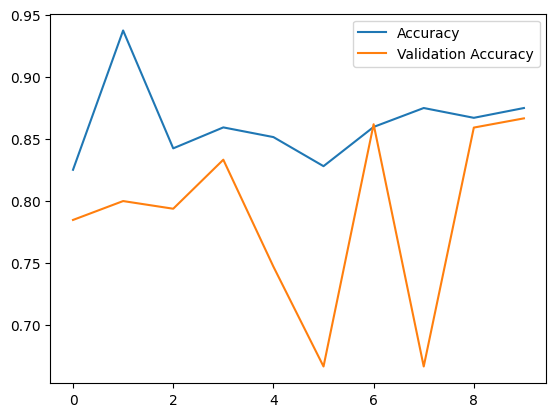

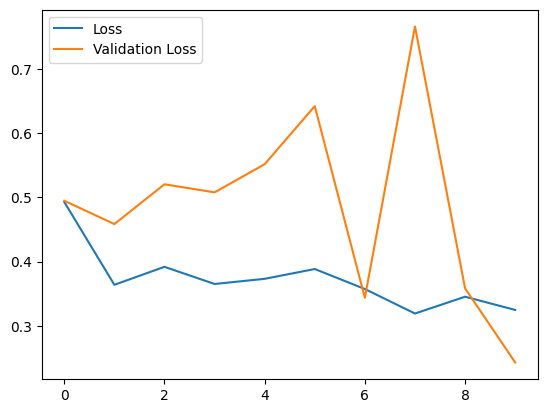

In [10]:
# Plot accuracy and loss graphs after training
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [15]:
# Define paths to test data and submission file
test_dir = './kaggle/input/test'
submission_file = './submission.csv'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Predict on test data
test_generator.reset()

# Generate predictions (probabilities) for the test data
predictions = model.predict(test_generator, verbose=1,steps=test_generator.samples)

# Get the list of test image filenames (these will be used as 'id' in the submission)
test_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_generator.filenames]


# Create a dataframe for submission
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': (predictions > 0.53).astype(int).reshape(-1)
  # Flatten to ensure it's a 1D array
})

# Save the submission dataframe to a CSV file
submission_df.to_csv(submission_file, index=False)

print(f'Submission file created: {submission_file}')

Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step
Submission file created: ./submission.csv


Step 4:
Learnings:

Model Architecture and Improvements:

Baseline CNN Model: This provided initial predictions, but the performance could likely be improved with deeper architectures or using pretrained models like ResNet or EfficientNet.

Tuning Hyperparameters: Adjusting learning rates, batch sizes, and regularization parameters (such as dropout or weight decay) might further improve generalization.

Image Augmentation: Techniques such as rotation, zoom, and flips should help in making the model more robust to variations in tumor tissue orientation or size.

Training Process:

Early Stopping: Helped avoid overfitting by stopping training once validation performance plateaued.

Learning Rate Scheduler: Dynamic adjustment of the learning rate likely contributed to improved convergence.

GPU Acceleration: While TensorFlow's GPU utilization improved training speed, optimizing data pipeline (e.g., multi-threading, caching) would help with handling large datasets more efficiently, especially on non-GPU machines.


Areas for Future Improvement:

Pretrained Models: Experimenting with transfer learning from pretrained models could enhance performance without significantly increasing training time.

Ensemble Models: Combining predictions from multiple models with different architectures or hyperparameters might provide better generalization.

Data Preprocessing: Ensuring robust data preprocessing, including normalization and handling of imbalanced classes, could help reduce model biases.

Cross-Validation: To better assess model generalization, employing k-fold cross-validation might give a more reliable estimate of performance on unseen data.